In [ ]:
#Adding the libraries

import matplotlib.pyplot as plt #For image plotting
from matplotlib import cm
from PIL import Image #For inline display of images only
from google.colab.patches import cv2_imshow
import numpy as np
import cv2 #Image based operations
import os  #File operations in local directory
import glob #Match filepth for the expressions
import random as rand #Randomising data

#For Unet architecture implementation, import:
#Layers from tensorflow keras such as Maxpool, Dense, Conv2D....
import tensorflow as tf
from tensorflow.keras.layers import Activation, Dense, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, Input, Cropping2D, Flatten
from tensorflow.keras import Model #Neural net model
#Plot model for graphical visualisation of model architecture
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as B #Tensorflow backend fuctions
import pydot,graphviz #Plotting tool required by plot_model

In [ ]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Auxillary functions

#Function to generate relative path list for files of specific extension in directory
def listFiles(path,ext):
  flist=glob.glob(path+'*.'+ext) #List files matching extension in path
  flist.sort() #Sort the path list
  return flist

#Function to pad image ()default relect the cormers and edges
def imPad(img,width,mode='reflect'):
    if len(img.shape)==2:
        #For Grey scale image
        img_pad=np.pad(img, pad_width=((width, width), (width, width)), mode=mode) #Pad length and width
    elif len(img.shape)==3:
        #For Color image
        img_pad=np.pad(img, pad_width=((width, width), (width, width), (0, 0)), mode=mode) #Pad length, width and height
    return (img_pad)


def diceLoss(y_true, y_pred):
    smooth=1
    y_true_f = B.flatten(y_true)
    y_pred_f = B.flatten(y_pred)
    return 1-(2*B.sum(y_true_f*y_pred_f)+smooth)/(B.sum(y_true_f)+B.sum(y_pred_f)+smooth)
#
def diceScore(y_true, y_pred):
    return 1-DiceLoss(y_true, y_pred)
#
def diceLoss1(y_true, y_pred):
  print("ypred:",y_pred.shape)
  print("ytrue:",y_true.shape)
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.math.sigmoid(y_pred)
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)

  return 1 - numerator / denominator

#Ref: A survey of loss functions for semantic segmentation by Shruti Jadon
def DiceLoss(y_true, y_pred, smooth=1e-6):
    #flatten label and prediction tensors
    y_pred = B.flatten(y_pred) #Flattern to 1D Tensor of predicted value
    y_true = B.flatten(y_true) #Flattern to 1D Tensor of true value

    intersection = tf.reduce_sum(y_true*y_pred) #Compute the sum of multiplied tensors
    dice = (2*intersection + smooth) / (tf.reduce_sum(y_true) + B.sum(y_pred) + smooth) #Compute dice score
    #Loss=1-score
    return 1 - dice




**Question 1**

**Reading and displaying the image**

In [ ]:
#File paths for the train data set(X:input:Tissue image,Y:Output: Mask (B&W or Color))
xtrain_path=r'/content/drive/MyDrive/MoNuSeg-Training-Data/Tissue-Images/'
ybtrain_path=r'/content/drive/MyDrive/MoNuSeg-Training-Data/Binary-Mask/'
yctrain_path=r'/content/drive/MyDrive/MoNuSeg-Training-Data/Color-Mask/'

#File paths for the test data set(X:input:Tissue image,Y:Output: Mask (B&W or Color))
xtest_path=r'/content/drive/MyDrive/MoNuSeg-Test-Data/Tissue-Images/'
ybtest_path=r'/content/drive/MyDrive/MoNuSeg-Test-Data/Binary-Mask/'
yctest_path=r'/content/drive/MyDrive/MoNuSeg-Test-Data/Color-Mask/'

#Generate path lists for Tissue image and Masks(B&W and Color)
xtrain_plist=listFiles(xtrain_path,'png')
ybtrain_plist=listFiles(ybtrain_path,'png')
yctrain_plist=listFiles(yctrain_path,'png')

#Generate path lists for Tissue image and Masks(B&W and Color)
xtest_plist=listFiles(xtest_path,'png')
ybtest_plist=listFiles(ybtest_path,'png')
yctest_plist=listFiles(yctest_path,'png')
#/content/drive/MyDrive/MoNuSeg-Test-Data/Binary-Mask/TCGA-2Z-A9J9-01A-01-TS1.png
#/content/drive/MyDrive/MoNuSeg-Test-Data/Tissue-Images/TCGA-2Z-A9J9-01A-01-TS1.png

In [ ]:
#Display Train Data

#Disply random set of Tissue image and Masks(B&W and Color)
index=np.arange(0,len(xtrain_plist)) #Gneertae the index for the input image path
rand.shuffle(index) #Randomize the index
index=index[0:3] #Select only the first 3 elements of randomised index

#Print the images and respective masks for the selete index
#Ierate over the index
for i in index:
    print("Train Image:"+str(i))
    img = cv2.imread(xtrain_plist[i],cv2.IMREAD_COLOR) #Print Tissue image
    cv2_imshow(img)
    print("Test Image(Binary Mask):"+str(i))
    img = cv2.imread(ybtrain_plist[i],cv2.IMREAD_GRAYSCALE) #Print Binary(B&W) Mask image
    cv2_imshow(img)
    print("Test Image(Color Mask):"+str(i))
    img = cv2.imread(yctrain_plist[i],cv2.IMREAD_COLOR) #Print Color Mask image
    cv2_imshow(img)


In [ ]:
#Display test Data

#Disply random set of Tissue image and Masks(B&W and Color)
index=np.arange(0,len(xtest_plist)) #Gneertae the index for the input image path
rand.shuffle(index) #Randomize the index
index=index[0:3] #Select only the first 3 elements of randomised index

#Print the images and respective masks for the selete index
#Ierate over the index
for i in index:
    print("Train Image:"+str(i))
    img = cv2.imread(xtest_plist[i],cv2.IMREAD_COLOR) #Print Tissue image
    cv2_imshow(img)
    print("Test Image(Binary Mask):"+str(i))
    img = cv2.imread(ybtest_plist[i],cv2.IMREAD_GRAYSCALE) #Print Binary(B&W) Mask image
    cv2_imshow(img)
    print("Test Image(Color Mask):"+str(i))
    img = cv2.imread(yctest_plist[i],cv2.IMREAD_COLOR) #Print Color Mask image
    cv2_imshow(img)


**Question 2**

**UNet Implementation for Semantic Segmentation**

In [ ]:
#Prepare train and test images
def proImgData(pathlist,isColor,padwidth=4):
    list_len=len(pathlist)
    if isColor:
        img_stack=np.empty([list_len,1000+2*padwidth,1000+2*padwidth,3])
        #img_stack=np.empty([list_len,572,572,3])
    else:
        img_stack=np.empty([list_len,1000+2*padwidth,1000+2*padwidth])
        #img_stack=np.empty([list_len,572,572])

    for idx,path in enumerate(pathlist):
        if isColor:
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            #img = cv2.resize(img, (572,572), interpolation = cv2.INTER_CUBIC)
            img = imPad(img,padwidth)
            img_stack[idx,:,:,:]=img
        else:
            img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            #img = cv2.resize(img, (572,572), interpolation = cv2.INTER_CUBIC)
            img = imPad(img,padwidth)
            img_stack[idx,:,:]=img

    img_stack = tf.cast(img_stack, tf.float32)/255.0
    return(img_stack)


xtrain=proImgData(xtrain_plist,isColor=True)
ybtrain=proImgData(ybtrain_plist,isColor=False)
xtest=proImgData(xtest_plist,isColor=True)
ybtest=proImgData(ybtest_plist,isColor=False)

**Unet Implmentation with Binary Cross Entropy**

In [ ]:
M=1008
F=32
initializer='he_normal'
#--------------------------------------------------------------------------------------------------------------------
x_input = tf.keras.layers.Input(shape =(M,M, 3))
#------------------------------Downstream Path-1----------------------------------------------------------------------
conv_1 = tf.keras.layers.Conv2D(F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(x_input)
conv_1 = tf.keras.layers.Conv2D(F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_1)
pool_1 = tf.keras.layers.MaxPooling2D((2, 2))(conv_1)
#------------------------------Downstream Path-2----------------------------------------------------------------------
conv_2 = tf.keras.layers.Conv2D(2*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(pool_1)
conv_2 = tf.keras.layers.Conv2D(2*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_2)
pool_2 = tf.keras.layers.MaxPooling2D((2, 2))(conv_2)
 #------------------------------Downstream Path-3---------------------------------------------------------------------
conv_3 = tf.keras.layers.Conv2D(4*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(pool_2)
conv_3 = tf.keras.layers.Conv2D(4*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_3)
pool_3 = tf.keras.layers.MaxPooling2D((2, 2))(conv_3)
 #------------------------------Downstream Path-4----------------------------------------------------------------------
conv_4 = tf.keras.layers.Conv2D(8*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(pool_3)
conv_4 = tf.keras.layers.Conv2D(8*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_4)
pool_4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_4)
 #------------------------------Bottleneck-----------------------------------------------------------------------------
conv_5 = tf.keras.layers.Conv2D(16*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(pool_4)
conv_5 = tf.keras.layers.Conv2D(16*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_5)
#------------------------------Upstream Path-1------------------------------------------------------------------------
uconv_6 = tf.keras.layers.Conv2DTranspose(32*F, (2, 2), strides=(2, 2), padding='same')(conv_5)
uconv_6 = tf.keras.layers.concatenate([uconv_6, conv_4])
conv_6 = tf.keras.layers.Conv2D(8*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(uconv_6)
conv_6 = tf.keras.layers.Conv2D(8*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_6)
 #------------------------------Upstream Path-2------------------------------------------------------------------------
uconv_7 = tf.keras.layers.Conv2DTranspose(4*F, (2, 2), strides=(2, 2), padding='same')(conv_6)
uconv_7 = tf.keras.layers.concatenate([uconv_7, conv_3])
conv_7 = tf.keras.layers.Conv2D(4*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(uconv_7)
conv_7 = tf.keras.layers.Conv2D(4*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_7)
 #------------------------------Upstream Path-3------------------------------------------------------------------------
uconv_8 = tf.keras.layers.Conv2DTranspose(2*F, (2, 2), strides=(2, 2), padding='same')(conv_7)
uconv_8 = tf.keras.layers.concatenate([uconv_8, conv_2])
conv_8 = tf.keras.layers.Conv2D(2*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(uconv_8)
conv_8 = tf.keras.layers.Conv2D(2*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_8)
 #------------------------------Upstream Path-4------------------------------------------------------------------------
uconv_9 = tf.keras.layers.Conv2DTranspose(F, (2, 2), strides=(2, 2), padding='same')(conv_8)
uconv_9 = tf.keras.layers.concatenate([uconv_9, conv_1], axis=3)
conv_9 = tf.keras.layers.Conv2D(F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(uconv_9)
conv_9 = tf.keras.layers.Conv2D(F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_9)
 #------------------------------Output------------------------------------------------------------------------------
outputs = tf.keras.layers.Conv2D(2, (1, 1), activation='sigmoid')(conv_9)

model = tf.keras.Model(inputs=[x_input], outputs=[outputs])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary()) #Print model summary
#model.compile(optimizer='adam', loss=diceLoss,metrics=[diceScore])
history=model.fit(xtrain, ybtrain, batch_size=2, epochs=20, verbose=1, shuffle=True,validation_split=0.2)

#Reference: https://github.com/nikhilroxtomar/UNet-Segmentation-in-Keras-TensorFlow/blob/master/unet-segmentation.ipynb

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1008, 1008,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_19 (Conv2D)             (None, 1008, 1008,   896         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 1008, 1008,   9248        ['conv2d_19[0][0]']              
                                32)                                                         

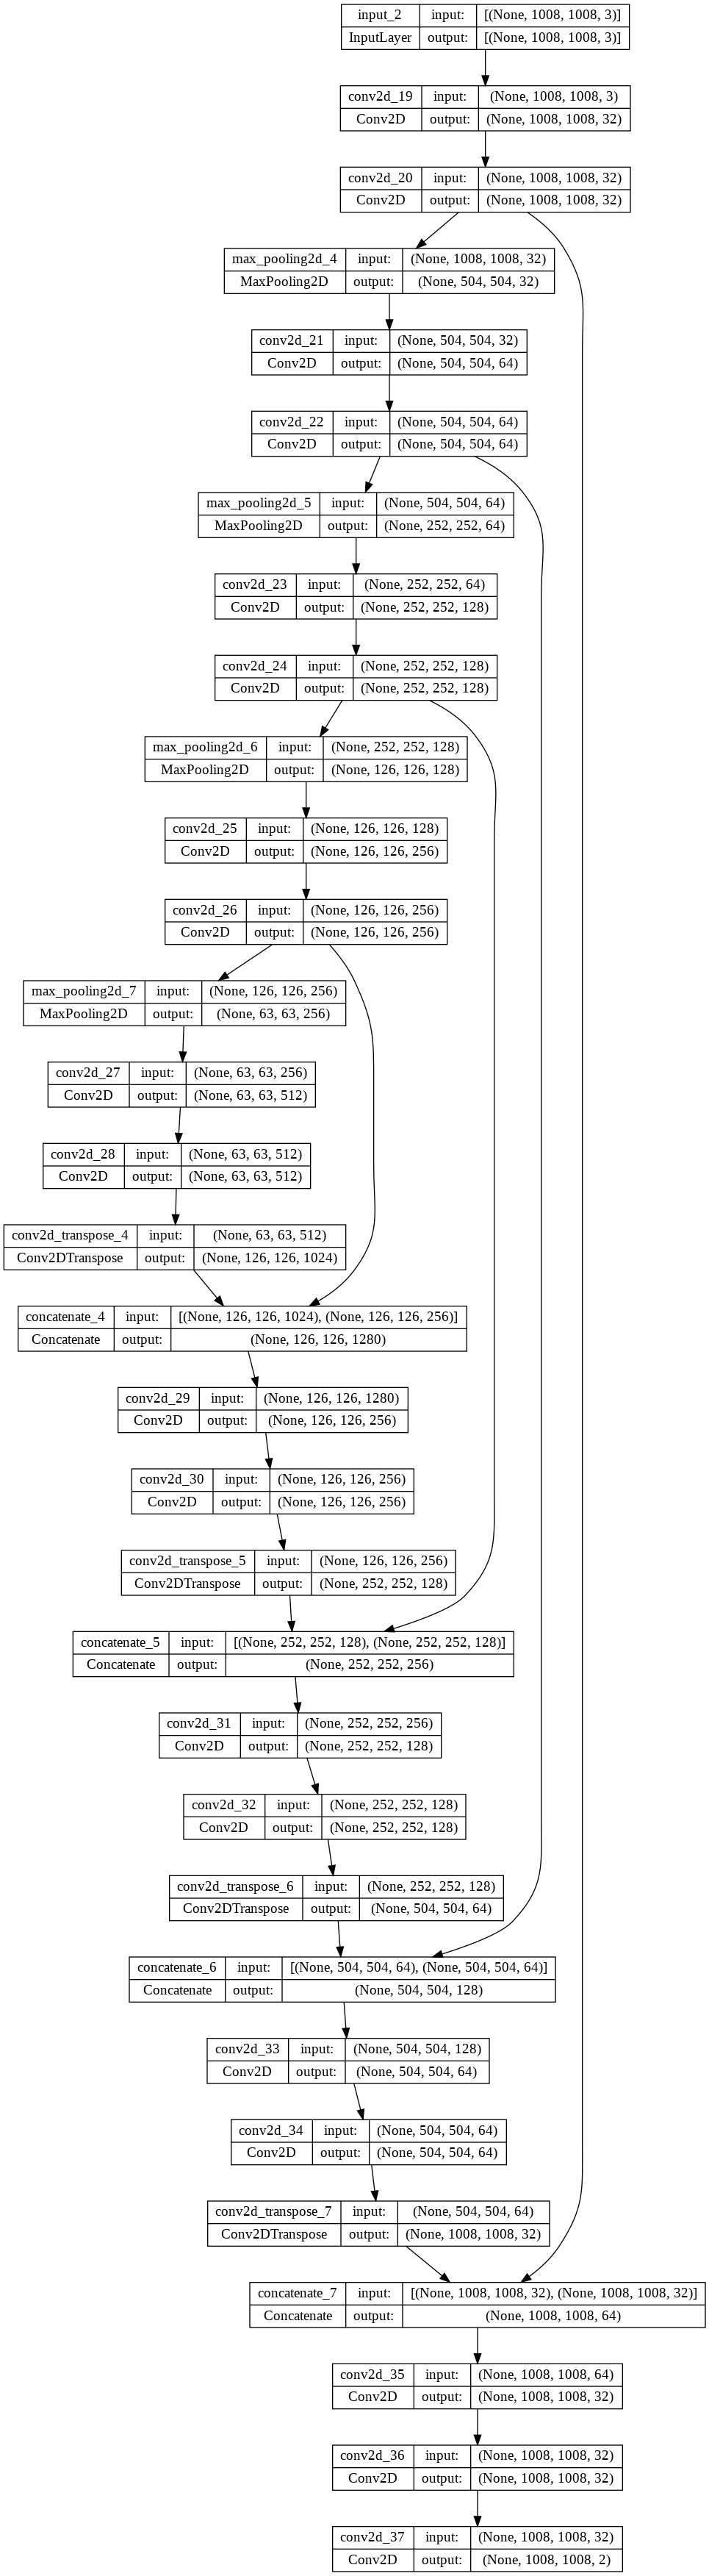

In [ ]:
plot_model(model, to_file = "./Model.png", show_shapes=True) #Save model in graph

**Plotting Sparse Categorical Crossentropy Results**

In [ ]:
iter=2
padwidth=8
crop_length=2*padwidth
img_pred=np.empty((iter,M-crop_length,M-crop_length)).astype(int)
img_act=np.empty((iter,M-crop_length,M-crop_length)).astype(int)
y_pred=model.predict(xtest[0:iter,:,:,:])
for i in range(iter):
  tmp_img=1-y_pred[i,:,:,0]
  tmp_img[tmp_img>=5]=255
  tmp_img[tmp_img<5]=0
  tmp_img=tmp_img.astype(int)[padwidth:-padwidth,padwidth:-padwidth]
  img_pred[i,:,:]=tmp_img

  img_act[i,:,:]=(np.array(ybtest[i,:,:])*255).astype(int)[padwidth:-padwidth,padwidth:-padwidth]



1/1 [==============================] - 0s 274ms/step


Image 1(Prediction)


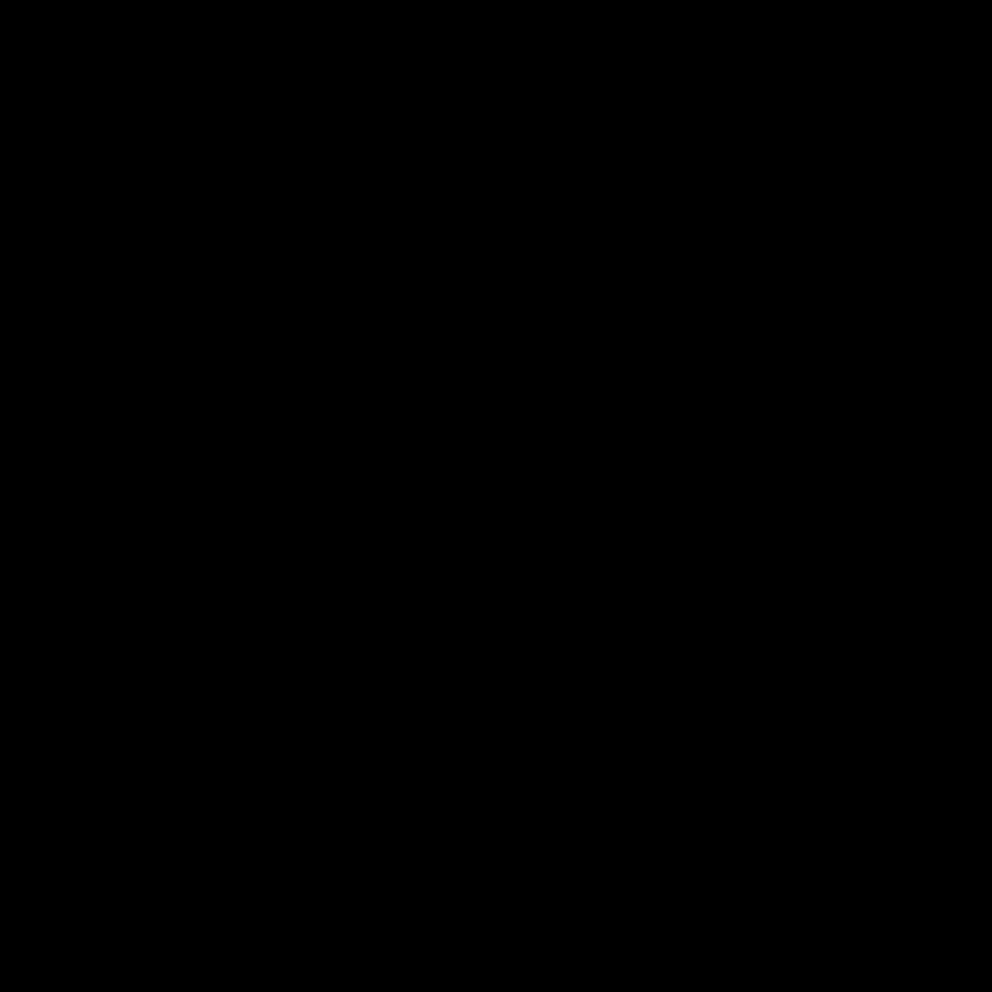

Image 1(Actual)


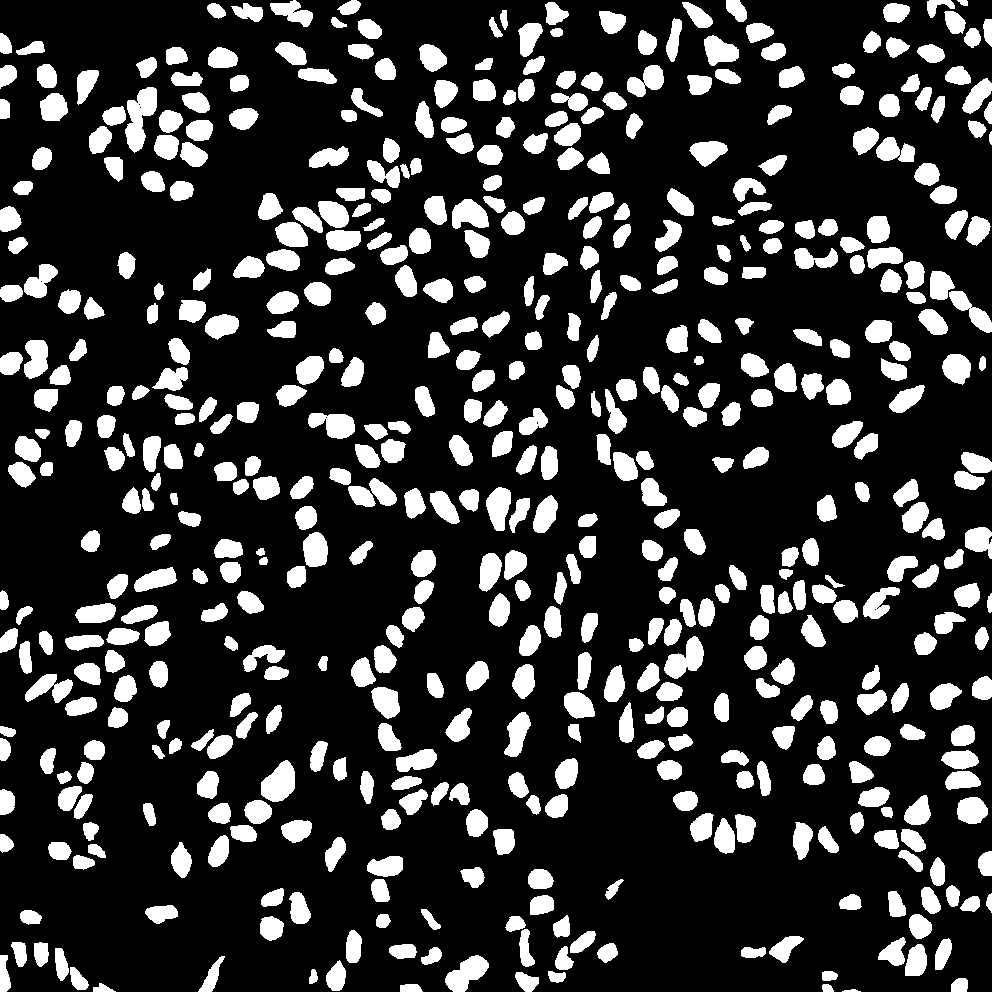

In [ ]:
print("Image 1(Prediction)")
cv2_imshow(img_pred[0,:,:])
img_watershed = img_pred[0,:,:]         #saving for later use in q6
print("Image 1(Actual)")
cv2_imshow(img_act[0,:,:])

**Question 3**

**Unet Implementation with Dice Loss**

In [ ]:
M=1008
F=35
initializer='he_normal'
#--------------------------------------------------------------------------------------------------------------------
x_input = tf.keras.layers.Input(shape =(M,M, 3))
#------------------------------Downstream Path-1----------------------------------------------------------------------
conv_1 = tf.keras.layers.Conv2D(F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(x_input)
conv_1 = tf.keras.layers.Conv2D(F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_1)
pool_1 = tf.keras.layers.MaxPooling2D((2, 2))(conv_1)
#------------------------------Downstream Path-2----------------------------------------------------------------------
conv_2 = tf.keras.layers.Conv2D(2*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(pool_1)
conv_2 = tf.keras.layers.Conv2D(2*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_2)
pool_2 = tf.keras.layers.MaxPooling2D((2, 2))(conv_2)
 #------------------------------Downstream Path-3---------------------------------------------------------------------
conv_3 = tf.keras.layers.Conv2D(4*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(pool_2)
conv_3 = tf.keras.layers.Conv2D(4*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_3)
pool_3 = tf.keras.layers.MaxPooling2D((2, 2))(conv_3)
 #------------------------------Downstream Path-4----------------------------------------------------------------------
conv_4 = tf.keras.layers.Conv2D(8*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(pool_3)
conv_4 = tf.keras.layers.Conv2D(8*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_4)
pool_4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_4)
 #------------------------------Bottleneck-----------------------------------------------------------------------------
conv_5 = tf.keras.layers.Conv2D(16*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(pool_4)
conv_5 = tf.keras.layers.Conv2D(16*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_5)
#------------------------------Upstream Path-1------------------------------------------------------------------------
uconv_6 = tf.keras.layers.Conv2DTranspose(32*F, (2, 2), strides=(2, 2), padding='same')(conv_5)
uconv_6 = tf.keras.layers.concatenate([uconv_6, conv_4])
conv_6 = tf.keras.layers.Conv2D(8*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(uconv_6)
conv_6 = tf.keras.layers.Conv2D(8*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_6)
 #------------------------------Upstream Path-2------------------------------------------------------------------------
uconv_7 = tf.keras.layers.Conv2DTranspose(4*F, (2, 2), strides=(2, 2), padding='same')(conv_6)
uconv_7 = tf.keras.layers.concatenate([uconv_7, conv_3])
conv_7 = tf.keras.layers.Conv2D(4*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(uconv_7)
conv_7 = tf.keras.layers.Conv2D(4*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_7)
 #------------------------------Upstream Path-3------------------------------------------------------------------------
uconv_8 = tf.keras.layers.Conv2DTranspose(2*F, (2, 2), strides=(2, 2), padding='same')(conv_7)
uconv_8 = tf.keras.layers.concatenate([uconv_8, conv_2])
conv_8 = tf.keras.layers.Conv2D(2*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(uconv_8)
conv_8 = tf.keras.layers.Conv2D(2*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_8)
 #------------------------------Upstream Path-4------------------------------------------------------------------------
uconv_9 = tf.keras.layers.Conv2DTranspose(F, (2, 2), strides=(2, 2), padding='same')(conv_8)
uconv_9 = tf.keras.layers.concatenate([uconv_9, conv_1], axis=3)
conv_9 = tf.keras.layers.Conv2D(F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(uconv_9)
conv_9 = tf.keras.layers.Conv2D(F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_9)
 #------------------------------Output------------------------------------------------------------------------------
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv_9)

model = tf.keras.Model(inputs=[x_input], outputs=[outputs])
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary()) #Print model summary
model.compile(optimizer='adam', loss=DiceLoss,metrics=[diceScore])
history=model.fit(xtrain, ybtrain, batch_size=5, epochs=10, verbose=1, shuffle=True,validation_split=0.2)

#Reference: https://github.com/nikhilroxtomar/UNet-Segmentation-in-Keras-TensorFlow/blob/master/unet-segmentation.ipynb

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1008, 1008,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_38 (Conv2D)             (None, 1008, 1008,   980         ['input_3[0][0]']                
                                35)                                                               
                                                                                                  
 conv2d_39 (Conv2D)             (None, 1008, 1008,   11060       ['conv2d_38[0][0]']              
                                35)                                                         

Used ReLu activation function and got the dice score =  0.4405

**Question 4**

**Plotting Unet results with diceLoss**

In [ ]:
iter=2
padwidth=8
crop_length=2*padwidth
img_pred=np.empty((iter,M-crop_length,M-crop_length)).astype(int)
img_act=np.empty((iter,M-crop_length,M-crop_length)).astype(int)
y_pred=model.predict(xtest[0:iter,:,:,:])
for i in range(iter):
  tmp_img=y_pred[i,:,:,0]
  tmp_img[tmp_img>0.5]=255
  tmp_img[tmp_img<=0.5]=0
  tmp_img=tmp_img.astype(int)[padwidth:-padwidth,padwidth:-padwidth]
  img_pred[i,:,:]=tmp_img

  img_act[i,:,:]=(np.array(ybtest[i,:,:])*255).astype(int)[padwidth:-padwidth,padwidth:-padwidth]


1/1 [==============================] - 10s 10s/step


Image 1(Prediction)


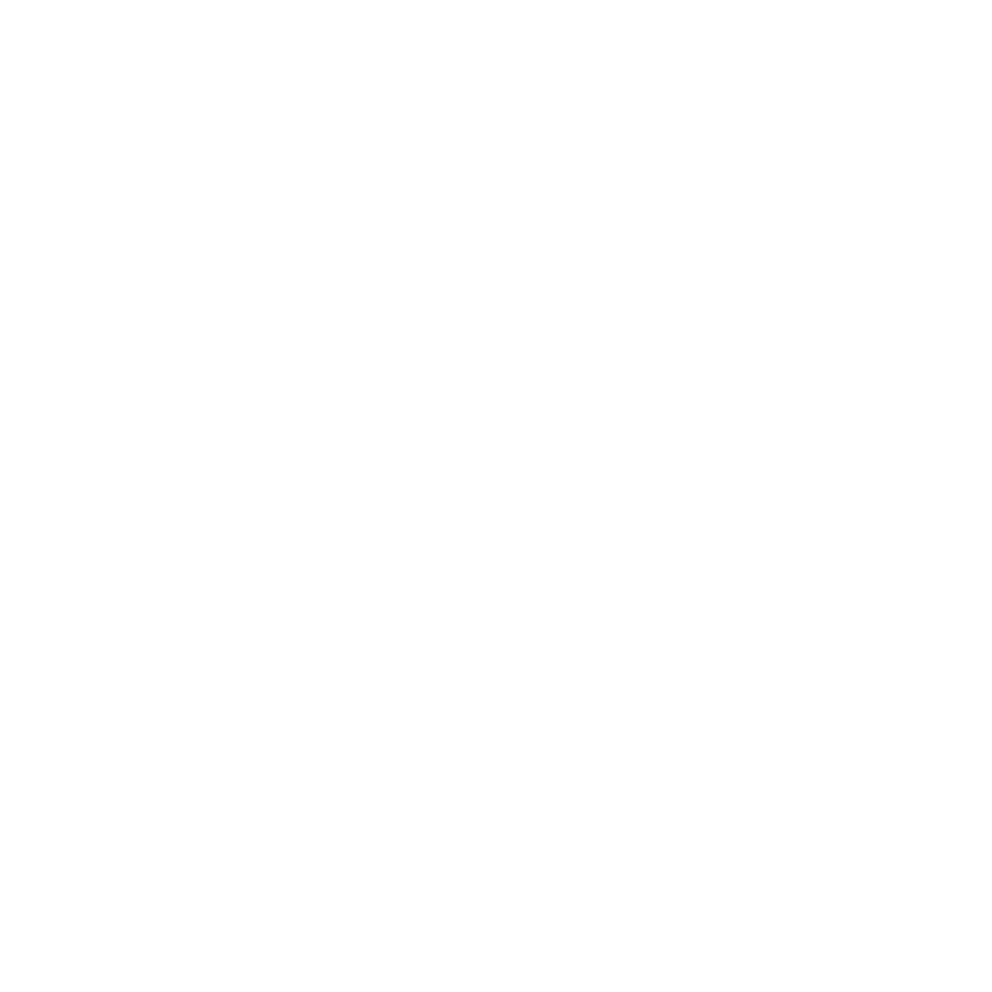

Image 1(Actual)


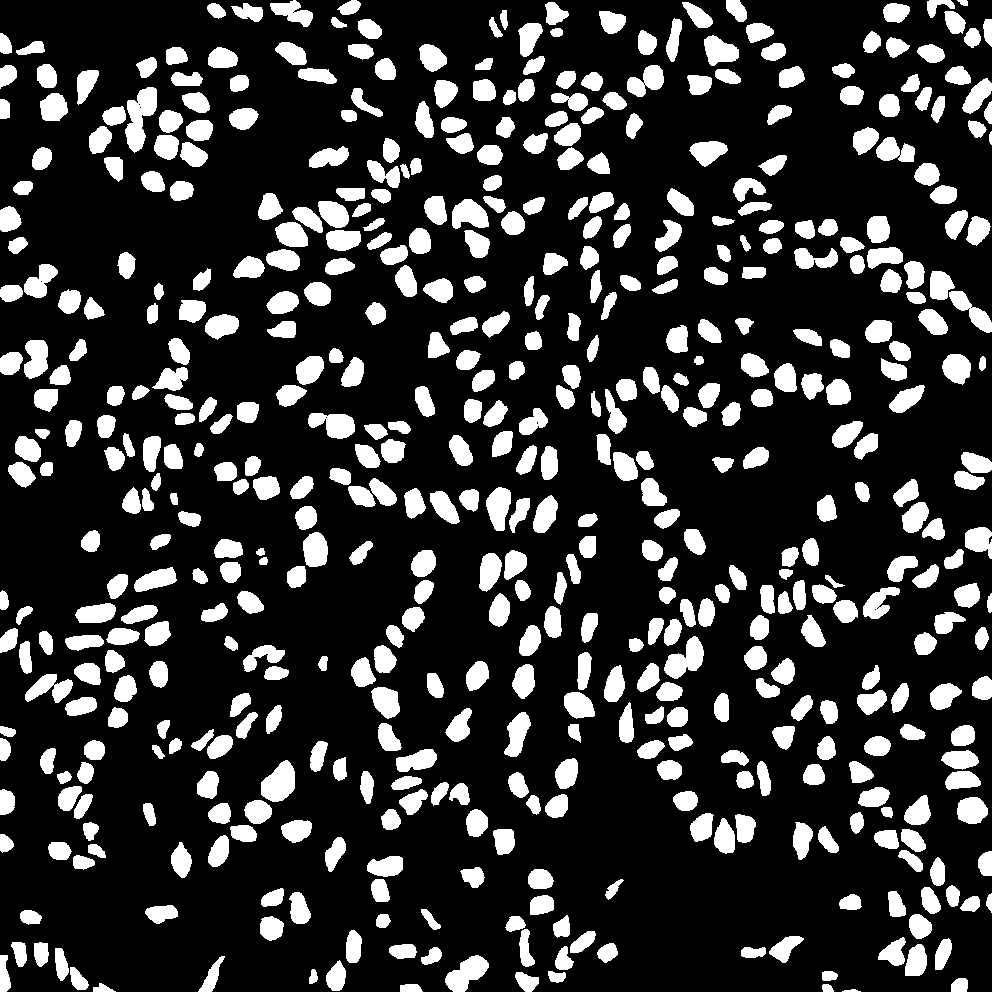

In [ ]:
print("Image 1(Prediction)")
cv2_imshow(img_pred[0,:,:])
print("Image 1(Actual)")
cv2_imshow(img_act[0,:,:])

In [ ]:
y_pred=model.predict(xtest[0:iter,:,:,:])

1/1 [==============================] - 0s 38ms/step


In [ ]:
np.max(y_pred[0,:,:,:])

1.0

**Question 5**

**Modification of the baseline architecture**

**Part A**

**Number of blocks in the UNet architecture**

In [ ]:
M=1008
F=32
initializer='he_normal'
'he_normal'
#--------------------------------------------------------------------------------------------------------------------
x_input = tf.keras.layers.Input(shape =(M,M, 3))
#------------------------------Downstream Path-1----------------------------------------------------------------------
conv_1 = tf.keras.layers.Conv2D(F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(x_input)
conv_1 = tf.keras.layers.Conv2D(F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_1)
conv_1a = tf.keras.layers.Conv2D(F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_1)
pool_1 = tf.keras.layers.MaxPooling2D((2, 2))(conv_1a)
#------------------------------Downstream Path-2----------------------------------------------------------------------
conv_2 = tf.keras.layers.Conv2D(2*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(pool_1)
conv_2 = tf.keras.layers.Conv2D(2*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_2)
conv_2a = tf.keras.layers.Conv2D(2*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_2)
pool_2 = tf.keras.layers.MaxPooling2D((2, 2))(conv_2a)
 #------------------------------Downstream Path-3---------------------------------------------------------------------
conv_3 = tf.keras.layers.Conv2D(4*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(pool_2)
conv_3 = tf.keras.layers.Conv2D(4*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_3)
conv_3a = tf.keras.layers.Conv2D(4*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_3)
pool_3 = tf.keras.layers.MaxPooling2D((2, 2))(conv_3a)
 #------------------------------Downstream Path-4----------------------------------------------------------------------
conv_4 = tf.keras.layers.Conv2D(8*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(pool_3)
conv_4 = tf.keras.layers.Conv2D(8*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_4)
conv_4a = tf.keras.layers.Conv2D(8*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_4)
pool_4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_4a)
 #------------------------------Bottleneck-----------------------------------------------------------------------------
conv_5 = tf.keras.layers.Conv2D(16*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(pool_4)
conv_5 = tf.keras.layers.Conv2D(16*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_5)
#------------------------------Upstream Path-1------------------------------------------------------------------------
uconv_6 = tf.keras.layers.Conv2DTranspose(32*F, (2, 2), strides=(2, 2), padding='same')(conv_5)
uconv_6 = tf.keras.layers.concatenate([uconv_6, conv_4])
conv_6 = tf.keras.layers.Conv2D(8*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(uconv_6)
conv_6 = tf.keras.layers.Conv2D(8*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_6)
conv_6a = tf.keras.layers.Conv2D(8*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_6)
 #------------------------------Upstream Path-2------------------------------------------------------------------------
uconv_7 = tf.keras.layers.Conv2DTranspose(4*F, (2, 2), strides=(2, 2), padding='same')(conv_6a)
uconv_7 = tf.keras.layers.concatenate([uconv_7, conv_3])
conv_7 = tf.keras.layers.Conv2D(4*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(uconv_7)
conv_7 = tf.keras.layers.Conv2D(4*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_7)
conv_7a = tf.keras.layers.Conv2D(4*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_7)
 #------------------------------Upstream Path-3------------------------------------------------------------------------
uconv_8 = tf.keras.layers.Conv2DTranspose(2*F, (2, 2), strides=(2, 2), padding='same')(conv_7a)
uconv_8 = tf.keras.layers.concatenate([uconv_8, conv_2])
conv_8 = tf.keras.layers.Conv2D(2*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(uconv_8)
conv_8 = tf.keras.layers.Conv2D(2*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_8)
conv_8a = tf.keras.layers.Conv2D(2*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_8)
 #------------------------------Upstream Path-4------------------------------------------------------------------------
uconv_9 = tf.keras.layers.Conv2DTranspose(F, (2, 2), strides=(2, 2), padding='same')(conv_8a)
uconv_9 = tf.keras.layers.concatenate([uconv_9, conv_1], axis=3)
conv_9 = tf.keras.layers.Conv2D(F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(uconv_9)
conv_9 = tf.keras.layers.Conv2D(F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_9)
conv_9a = tf.keras.layers.Conv2D(F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_9)
 #------------------------------Output------------------------------------------------------------------------------
outputs = tf.keras.layers.Conv2D(2, (1, 1), activation='sigmoid')(conv_9a)

model = tf.keras.Model(inputs=[x_input], outputs=[outputs])
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary()) #Print model summary
#model.compile(optimizer='adam', loss=DiceLoss,metrics=[diceScore])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history=model.fit(xtrain, ybtrain, batch_size=3, epochs=20, verbose=1, shuffle=True,validation_split=0.2)

In [ ]:
iter=2
padwidth=8
crop_length=2*padwidth
img_pred=np.empty((iter,M-crop_length,M-crop_length)).astype(int)
img_act=np.empty((iter,M-crop_length,M-crop_length)).astype(int)
y_pred=model.predict(xtest[0:iter,:,:,:])
for i in range(iter):
  tmp_img=y_pred[i,:,:,0]
  tmp_img[tmp_img>0.5]=255
  tmp_img[tmp_img<=0.5]=0
  tmp_img=tmp_img.astype(int)[padwidth:-padwidth,padwidth:-padwidth]
  img_pred[i,:,:]=tmp_img

  img_act[i,:,:]=(np.array(ybtest[i,:,:])*255).astype(int)[padwidth:-padwidth,padwidth:-padwidth]

print("Image 1(Prediction)")
cv2_imshow(img_pred[0,:,:])
print("Image 1(Actual)")
cv2_imshow(img_act[0,:,:])

**Part 5b**

**Number of filters per layer in the UNet architecture**

In [ ]:
M=1008
F=50
initializer='he_normal'
#--------------------------------------------------------------------------------------------------------------------
x_input = tf.keras.layers.Input(shape =(M,M, 3))
#------------------------------Downstream Path-1----------------------------------------------------------------------
conv_1 = tf.keras.layers.Conv2D(F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(x_input)
conv_1 = tf.keras.layers.Conv2D(F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_1)
pool_1 = tf.keras.layers.MaxPooling2D((2, 2))(conv_1)
#------------------------------Downstream Path-2----------------------------------------------------------------------
conv_2 = tf.keras.layers.Conv2D(2*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(pool_1)
conv_2 = tf.keras.layers.Conv2D(2*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_2)
pool_2 = tf.keras.layers.MaxPooling2D((2, 2))(conv_2)
 #------------------------------Downstream Path-3---------------------------------------------------------------------
conv_3 = tf.keras.layers.Conv2D(4*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(pool_2)
conv_3 = tf.keras.layers.Conv2D(4*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_3)
pool_3 = tf.keras.layers.MaxPooling2D((2, 2))(conv_3)
 #------------------------------Downstream Path-4----------------------------------------------------------------------
conv_4 = tf.keras.layers.Conv2D(8*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(pool_3)
conv_4 = tf.keras.layers.Conv2D(8*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_4)
pool_4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_4)
 #------------------------------Bottleneck-----------------------------------------------------------------------------
conv_5 = tf.keras.layers.Conv2D(16*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(pool_4)
conv_5 = tf.keras.layers.Conv2D(16*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_5)
#------------------------------Upstream Path-1------------------------------------------------------------------------
uconv_6 = tf.keras.layers.Conv2DTranspose(32*F, (2, 2), strides=(2, 2), padding='same')(conv_5)
uconv_6 = tf.keras.layers.concatenate([uconv_6, conv_4])
conv_6 = tf.keras.layers.Conv2D(8*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(uconv_6)
conv_6 = tf.keras.layers.Conv2D(8*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_6)
 #------------------------------Upstream Path-2------------------------------------------------------------------------
uconv_7 = tf.keras.layers.Conv2DTranspose(4*F, (2, 2), strides=(2, 2), padding='same')(conv_6)
uconv_7 = tf.keras.layers.concatenate([uconv_7, conv_3])
conv_7 = tf.keras.layers.Conv2D(4*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(uconv_7)
conv_7 = tf.keras.layers.Conv2D(4*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_7)
 #------------------------------Upstream Path-3------------------------------------------------------------------------
uconv_8 = tf.keras.layers.Conv2DTranspose(2*F, (2, 2), strides=(2, 2), padding='same')(conv_7)
uconv_8 = tf.keras.layers.concatenate([uconv_8, conv_2])
conv_8 = tf.keras.layers.Conv2D(2*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(uconv_8)
conv_8 = tf.keras.layers.Conv2D(2*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_8)
 #------------------------------Upstream Path-4------------------------------------------------------------------------
uconv_9 = tf.keras.layers.Conv2DTranspose(F, (2, 2), strides=(2, 2), padding='same')(conv_8)
uconv_9 = tf.keras.layers.concatenate([uconv_9, conv_1], axis=3)
conv_9 = tf.keras.layers.Conv2D(F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(uconv_9)
conv_9 = tf.keras.layers.Conv2D(F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_9)
 #------------------------------Output------------------------------------------------------------------------------
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv_9)

model = tf.keras.Model(inputs=[x_input], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary()) #Print model summary
#model.compile(optimizer='adam', loss=diceLoss,metrics=[diceScore])
history=model.fit(xtrain, ybtrain, batch_size=2, epochs=20, verbose=1, shuffle=True,validation_split=0.2)
#diceMSSIM

In [ ]:
iter=2
padwidth=8
crop_length=2*padwidth
img_pred=np.empty((iter,M-crop_length,M-crop_length)).astype(int)
img_act=np.empty((iter,M-crop_length,M-crop_length)).astype(int)
y_pred=model.predict(xtest[0:iter,:,:,:])
for i in range(iter):
  tmp_img=y_pred[i,:,:,0]
  tmp_img[tmp_img>0.5]=255
  tmp_img[tmp_img<=0.5]=0
  tmp_img=tmp_img.astype(int)[padwidth:-padwidth,padwidth:-padwidth]
  img_pred[i,:,:]=tmp_img

  img_act[i,:,:]=(np.array(ybtest[i,:,:])*255).astype(int)[padwidth:-padwidth,padwidth:-padwidth]

print("Image 1(Prediction)")
cv2_imshow(img_pred[0,:,:])
print("Image 1(Actual)")
cv2_imshow(img_act[0,:,:])

**Part 5c**

**Loss function as a combination of Dice and MS-SSIM with a trade-off parameter**

In [ ]:
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

In [ ]:
M=1008
F=16
initializer='he_normal'
#--------------------------------------------------------------------------------------------------------------------
x_input = tf.keras.layers.Input(shape =(M,M, 3))
#------------------------------Downstream Path-1----------------------------------------------------------------------
conv_1 = tf.keras.layers.Conv2D(F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(x_input)
conv_1 = tf.keras.layers.Conv2D(F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_1)
pool_1 = tf.keras.layers.MaxPooling2D((2, 2))(conv_1)
#------------------------------Downstream Path-2----------------------------------------------------------------------
conv_2 = tf.keras.layers.Conv2D(2*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(pool_1)
conv_2 = tf.keras.layers.Conv2D(2*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_2)
pool_2 = tf.keras.layers.MaxPooling2D((2, 2))(conv_2)
 #------------------------------Downstream Path-3---------------------------------------------------------------------
conv_3 = tf.keras.layers.Conv2D(4*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(pool_2)
conv_3 = tf.keras.layers.Conv2D(4*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_3)
pool_3 = tf.keras.layers.MaxPooling2D((2, 2))(conv_3)
 #------------------------------Downstream Path-4----------------------------------------------------------------------
conv_4 = tf.keras.layers.Conv2D(8*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(pool_3)
conv_4 = tf.keras.layers.Conv2D(8*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_4)
pool_4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_4)
 #------------------------------Bottleneck-----------------------------------------------------------------------------
conv_5 = tf.keras.layers.Conv2D(16*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(pool_4)
conv_5 = tf.keras.layers.Conv2D(16*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_5)
#------------------------------Upstream Path-1------------------------------------------------------------------------
uconv_6 = tf.keras.layers.Conv2DTranspose(32*F, (2, 2), strides=(2, 2), padding='same')(conv_5)
uconv_6 = tf.keras.layers.concatenate([uconv_6, conv_4])
conv_6 = tf.keras.layers.Conv2D(8*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(uconv_6)
conv_6 = tf.keras.layers.Conv2D(8*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_6)
 #------------------------------Upstream Path-2------------------------------------------------------------------------
uconv_7 = tf.keras.layers.Conv2DTranspose(4*F, (2, 2), strides=(2, 2), padding='same')(conv_6)
uconv_7 = tf.keras.layers.concatenate([uconv_7, conv_3])
conv_7 = tf.keras.layers.Conv2D(4*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(uconv_7)
conv_7 = tf.keras.layers.Conv2D(4*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_7)
 #------------------------------Upstream Path-3------------------------------------------------------------------------
uconv_8 = tf.keras.layers.Conv2DTranspose(2*F, (2, 2), strides=(2, 2), padding='same')(conv_7)
uconv_8 = tf.keras.layers.concatenate([uconv_8, conv_2])
conv_8 = tf.keras.layers.Conv2D(2*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(uconv_8)
conv_8 = tf.keras.layers.Conv2D(2*F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_8)
 #------------------------------Upstream Path-4------------------------------------------------------------------------
uconv_9 = tf.keras.layers.Conv2DTranspose(F, (2, 2), strides=(2, 2), padding='same')(conv_8)
uconv_9 = tf.keras.layers.concatenate([uconv_9, conv_1], axis=3)
conv_9 = tf.keras.layers.Conv2D(F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(uconv_9)
conv_9 = tf.keras.layers.Conv2D(F, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(conv_9)
 #------------------------------Output------------------------------------------------------------------------------
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv_9)

#mssim = tf.pack(mssim, axis=0)
model = tf.keras.Model(inputs=[x_input], outputs=[outputs])
model.compile(optimizer='adam', loss=DiceLoss+0.4*MS_SSIM, metrics=[diceScore])
print(model.summary()) #Print model summary
#model.compile(optimizer='adam', loss=diceLoss,metrics=[diceScore])
history=model.fit(xtrain, ybtrain, batch_size=2, epochs=20, verbose=1, shuffle=True,validation_split=0.2)

Merging SSIM loss with Dice Loss is resulting in error during model compilation. The model compilation could not be carried with DiceLoss and MS-SSIM loss

**Question 6**

**Watershed segmentation on the probability map produced by the UNet**

In [ ]:
#import libraries
import cv2
import numpy as np
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow   #cv2_imshow to display the image

In [ ]:

#img_watershed = cv2.imread('/content/drive/MyDrive/MoNuSeg-Test-Data/Binary-Mask/TCGA-2Z-A9J9-01A-01-TS1.png')


In [ ]:
def watershed_algorithm(img_watershed):
  gray_scale = cv2.cvtColor(img_watershed, cv2.COLOR_BGR2GRAY)       #converts the image to binary
  _,threshold = cv2.threshold(gray_scale, 0, 255, cv2.THRESH_BINARY_INV)   #taking binary inverse of the image which will make the pixels = 0 ( which are greater than threshold) or 1 for others
  print ('Image taken as input for watershed segmentation')
  cv2_imshow(img_watershed)
  print ('Image after inverse binary thresholding:')
  cv2_imshow(threshold)

 #calculate distance transform
  distance_transform = ndi.distance_transform_edt(threshold)       #calculates exact Euclidean distance transform
  dist_visual = distance_transform.copy()
  print('Distance transform of image')
  cv2_imshow (dist_visual)

  #local maximum calculation
  local_maximum = peak_local_max(distance_transform, indices=False, min_distance=20, labels=threshold)         #finds local maxima of points
  markers = ndi.label(local_maximum, structure=np.ones((3,3)))[0]     #labeling the local maximums of the image
  #inverting the distance transfrom to make local minima for watershed segmentation input
  labels = watershed(-distance_transform, markers, mask=threshold)    #applying watershed segmetation
  #print('Watershed Segmented Image')
  plt.title('Watershed Segmented Image')
  plt.imshow(labels, cmap="jet")

  return

#reference:https://felipemeganha.medium.com/image-segmentation-with-watershed-using-python-f40f2f7e9f40


Image taken as input for watershed segmentation


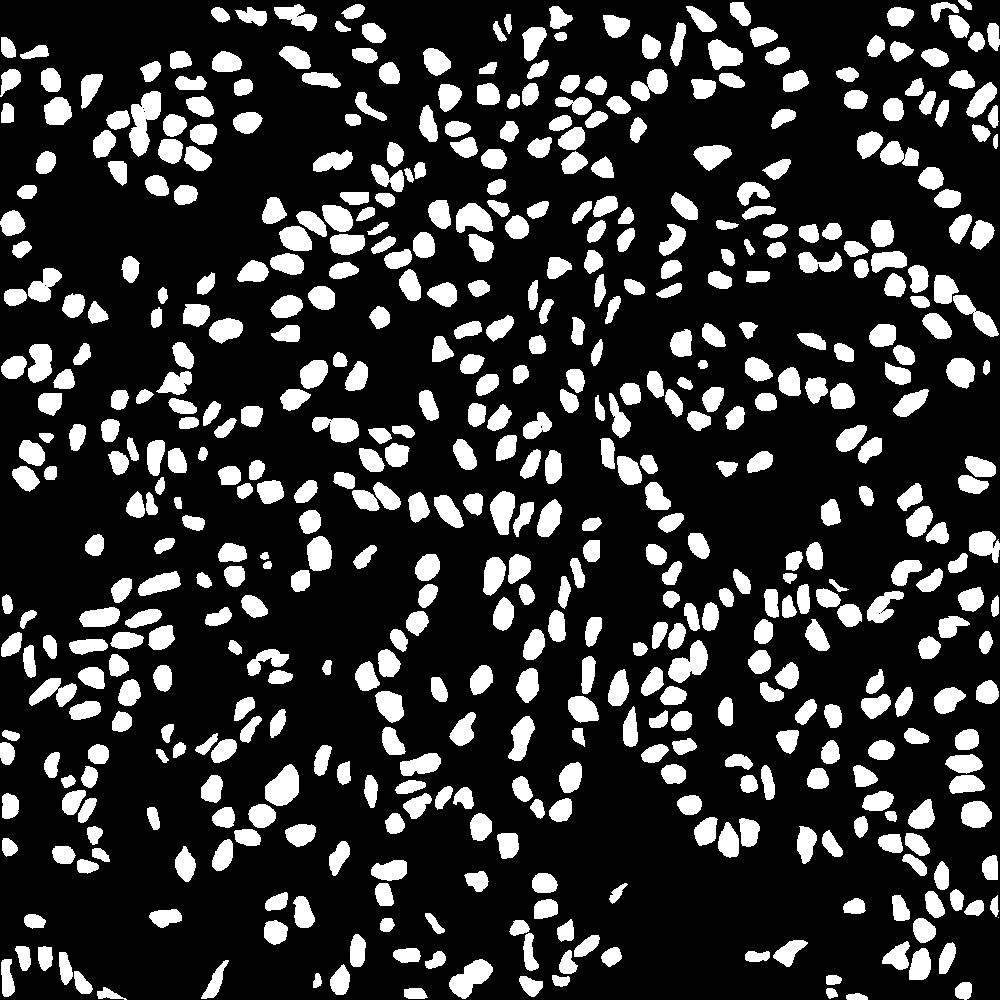

Image after inverse binary thresholding:


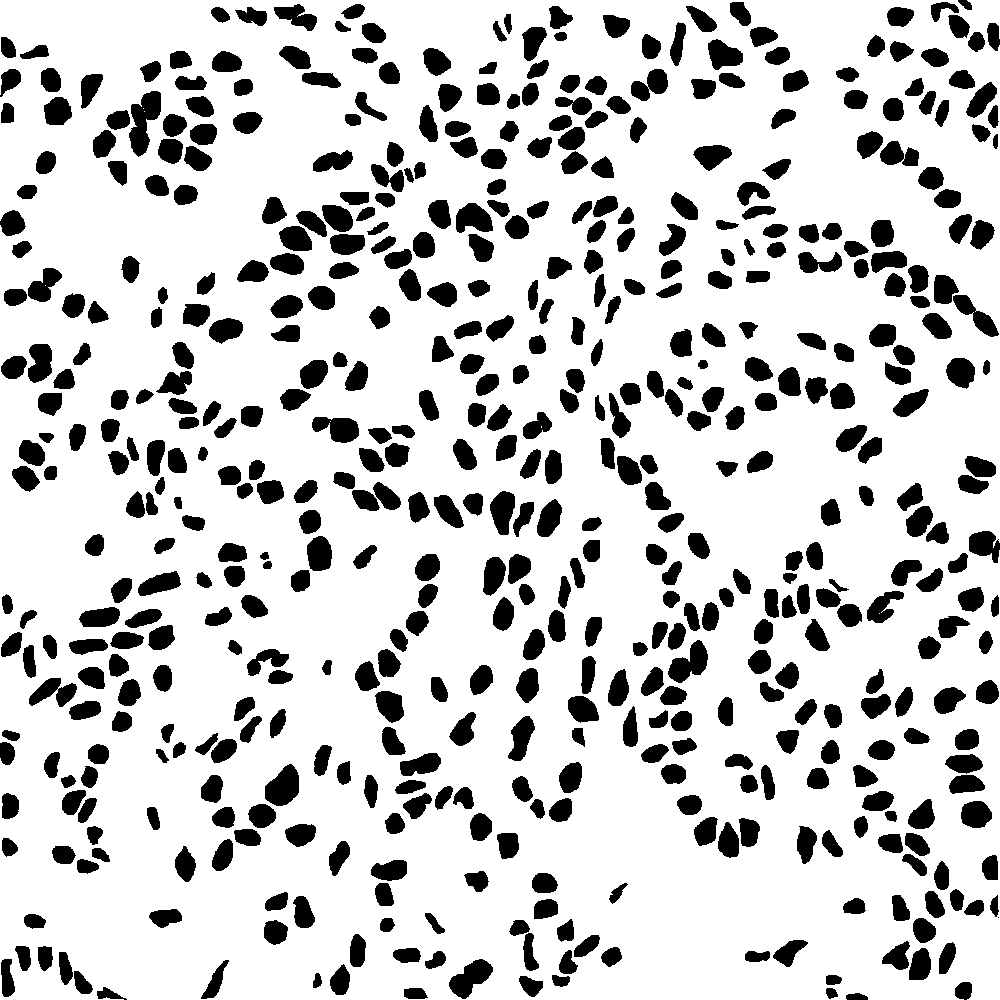

Distance transform of image


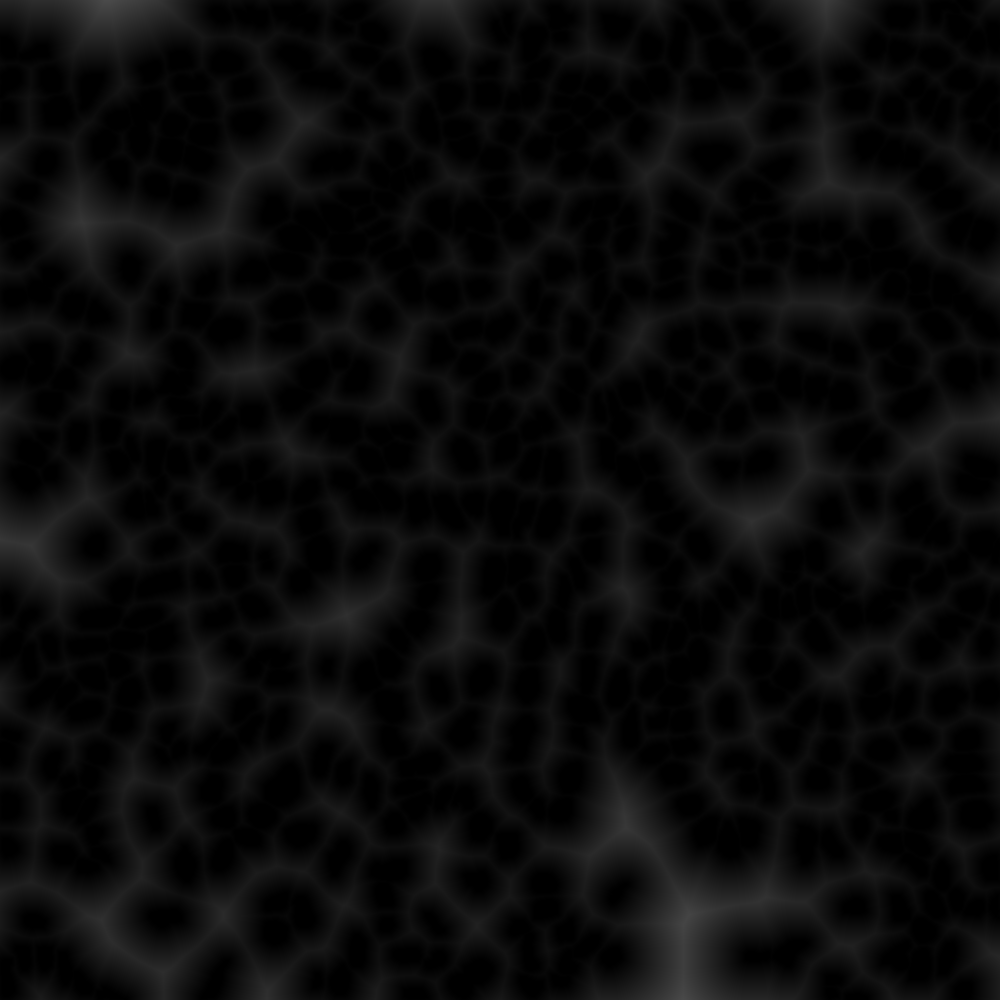

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  from ipykernel import kernelapp as app


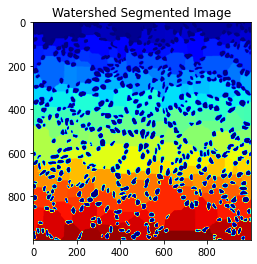

In [ ]:
#watershed segmentation on the output predicted by UNet
watershed_algorithm(img_watershed)

**Watershed segmentation results on test images with overlapping nuclei**

Image taken as input for watershed segmentation


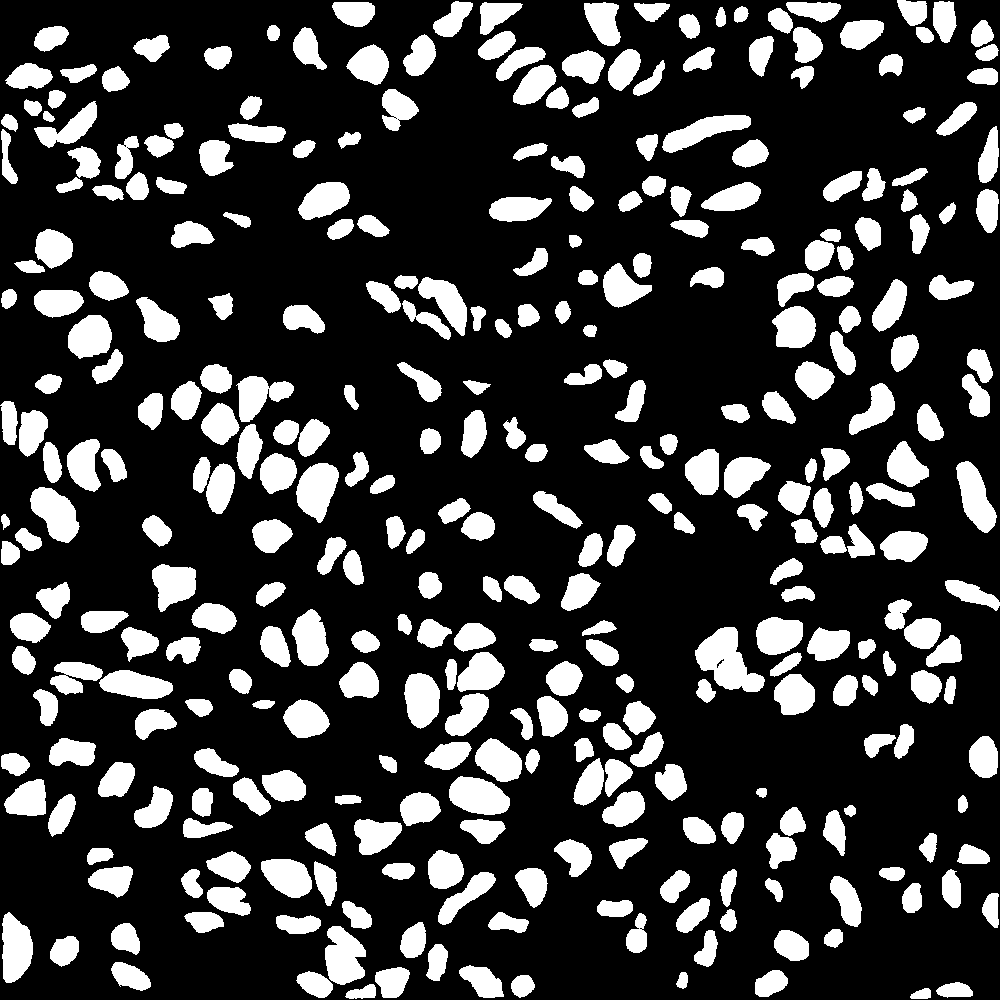

Image after inverse binary thresholding:


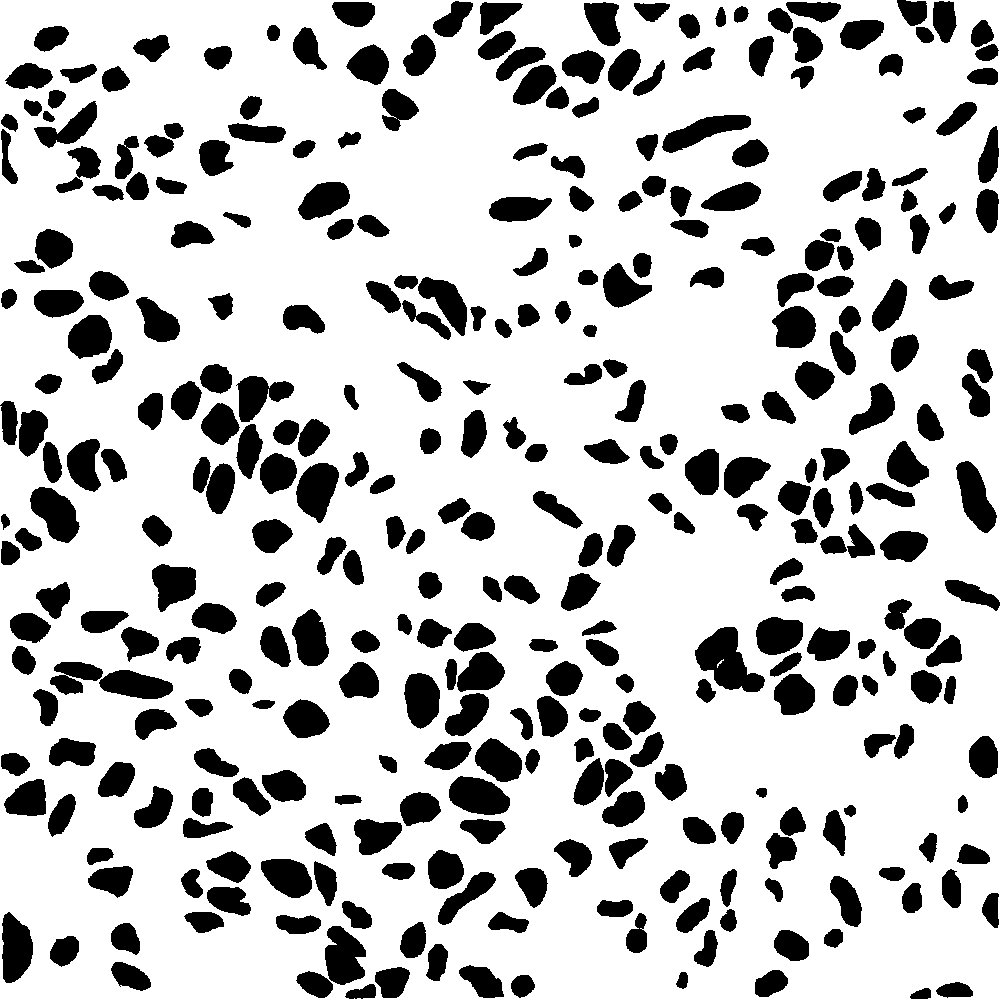

Distance transform of image


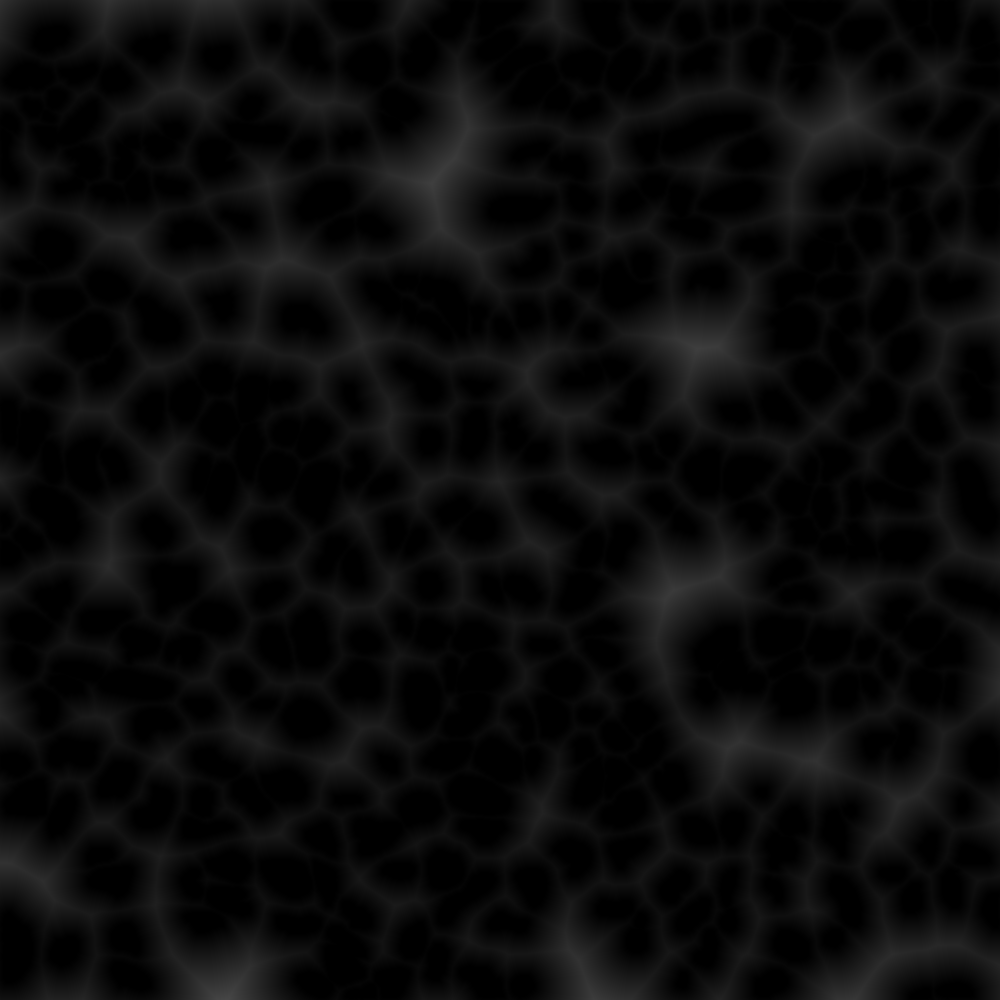

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  from ipykernel import kernelapp as app


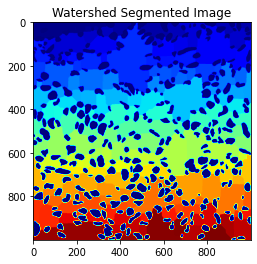

In [ ]:
overlapping_nuclei = cv2.imread('/content/drive/MyDrive/MoNuSeg-Test-Data/Binary-Mask/TCGA-AO-A0J2-01A-01-BSA.png')
watershed_algorithm(overlapping_nuclei)

Image taken as input for watershed segmentation


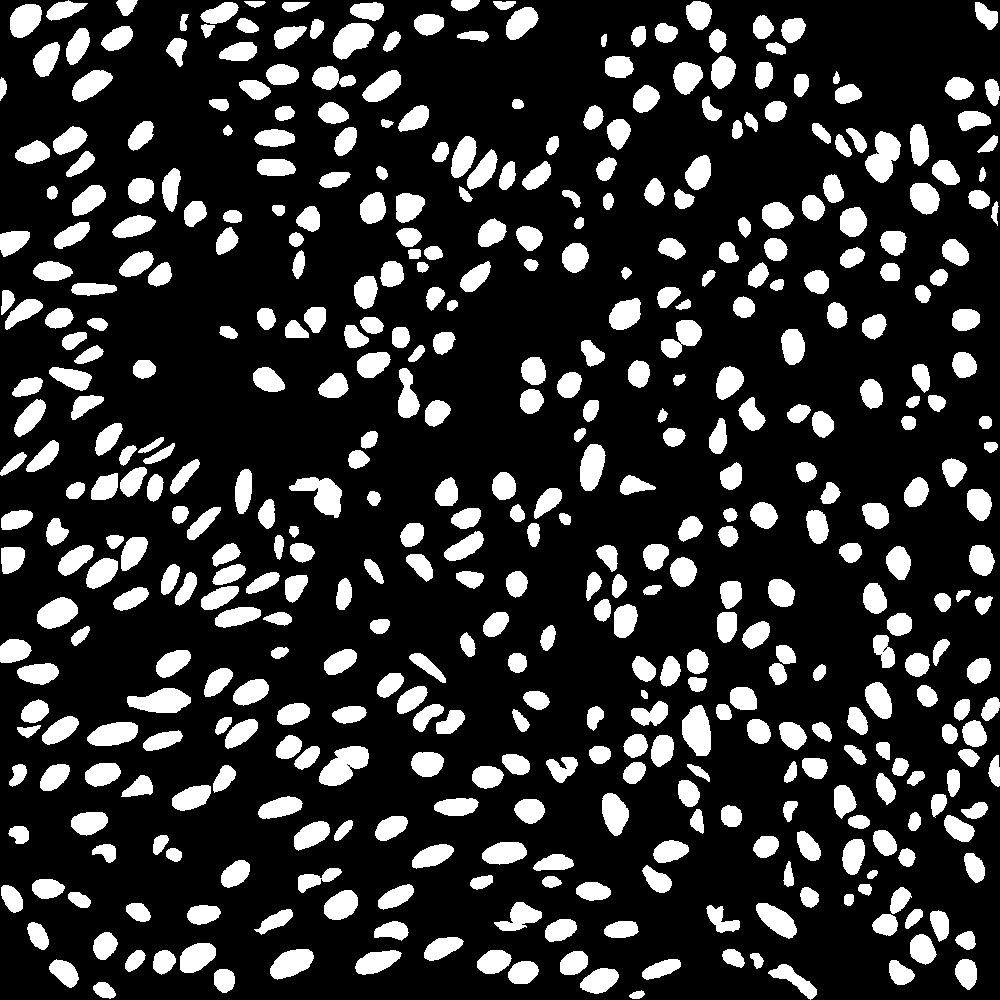

Image after inverse binary thresholding:


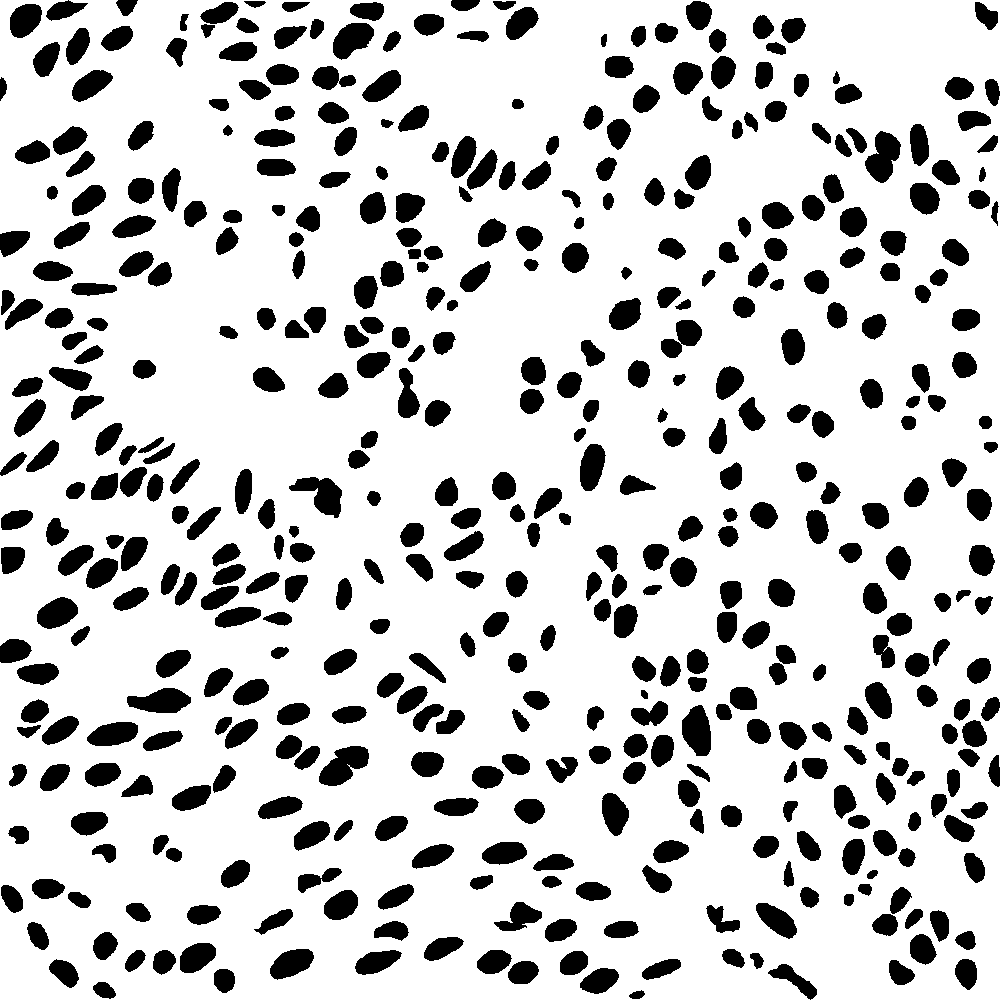

Distance transform of image


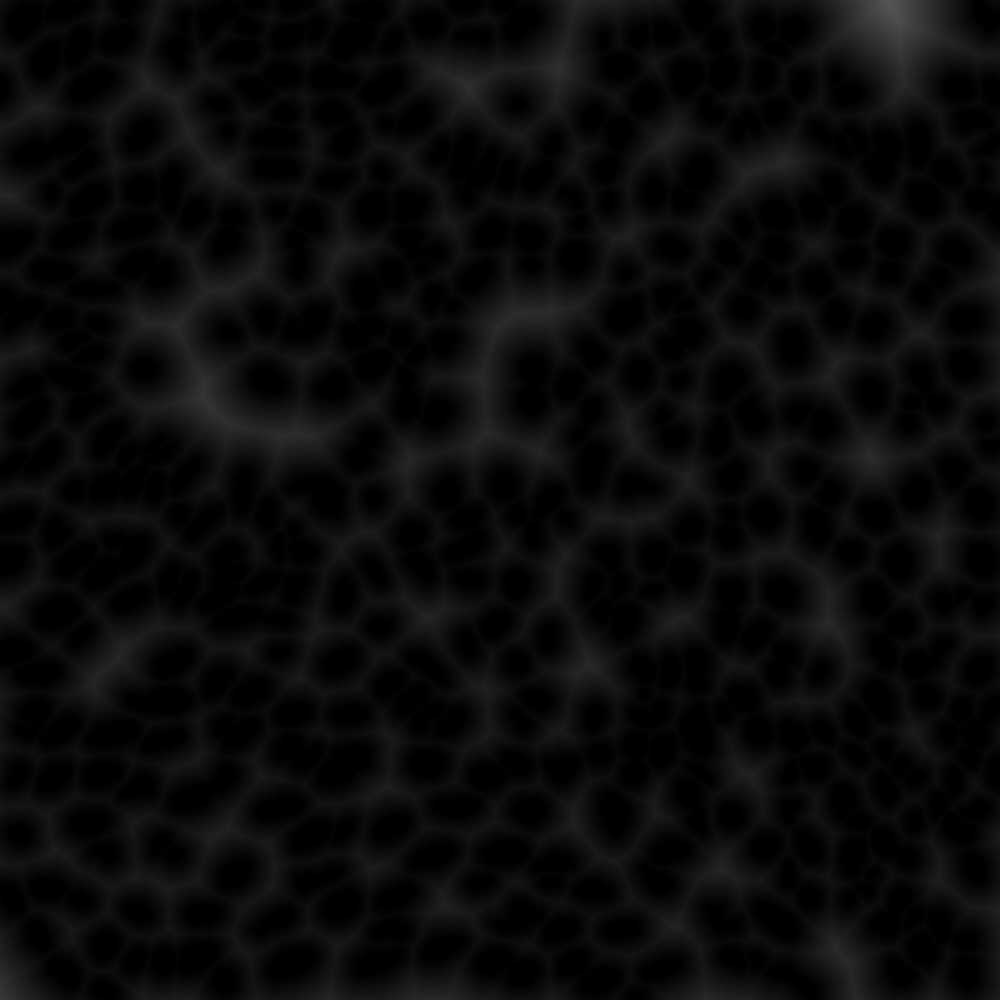

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  from ipykernel import kernelapp as app


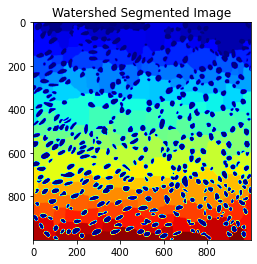

In [ ]:
overlapping_nuclei = cv2.imread('/content/drive/MyDrive/MoNuSeg-Test-Data/Binary-Mask/TCGA-ZF-A9R5-01A-01-TS1.png')
watershed_algorithm(overlapping_nuclei)